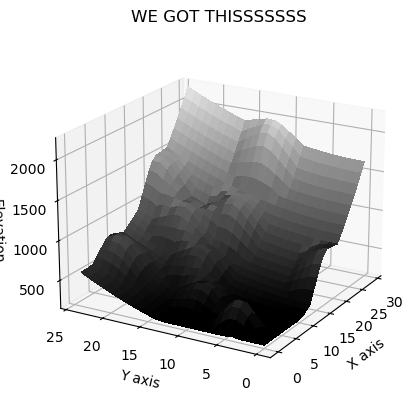

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from landlab import RasterModelGrid
from landlab.components import PriorityFloodFlowRouter
from landlab.plot.drainage_plot import drainage_plot

# This next section just has information I stole from the lab, I have not touched it at all. Perhaps we should leave it this way and just learn what it is fully saying.
def surf_plot(mg, surface="topographic__elevation", title="Surface plot of topography"):
    plt.figure()
    ax = plt.axes(projection="3d")
    
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    color = cm.gray((Z - Z.min()) / (Z.max() - Z.min()))
    ax.plot_surface(
        mg.x_of_node.reshape(mg.shape),
        mg.y_of_node.reshape(mg.shape),
        Z,
        rstride=1,
        cstride=1,
        facecolors=color,
        linewidth=0.0,
        antialiased=False,
    )
    ax.view_init(elev=20, azim=-150)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Elevation")
    plt.title(title)
    plt.show()

# Create the grid; the grid is 25 by 30 with a base elevation of whatever is below
mg = RasterModelGrid((25, 30))
x, y = mg.x_of_node, mg.y_of_node
base_elevation =1.0 + x**2.2 + y**2
mg.add_field("topographic__elevation", base_elevation, at="node")


# This is for the bumps, 10 bumps at nodes that are higher, like ridges, that have a slope across the closest nodes so they aren't scary tall solo points
num_bumps = 10
bump_height = 300
bump_radius = 4  # in grid units
sigma = bump_radius / 2.0

# Randomly choose 10 distinct nodes
#np.random.seed(42)  # this was a random seed that they gave me to begin with that picked a random grouping of higher nodes
#raised_nodes = np.random.choice(mg.number_of_nodes, size=num_bumps, replace=False)
raised_nodes = np.array([122, 17, 432, 667, 709, 387, 337, 409, 556, 154]) # Once we find a range of bumps we like we can use this so that the nodes are no longer random

# Add a Gaussian bump around each raised node, this makes it so that the nodes are sloped and not just one singular raised node
for node in raised_nodes:
    xc, yc = x[node], y[node]
    distances = np.sqrt((x - xc)**2 + (y - yc)**2)
    mask = distances < bump_radius
    bump = bump_height * np.exp(-((distances[mask])**2) / (2 * sigma**2))
    mg.at_node["topographic__elevation"][mask] += bump

# IF WE DONT WANT FLATTENED BOTTOM PORTION DELETE FROM HERE TO...
# Define floodplain threshold (e.g., lowest 10% of elevations), this picked out where the flattened area will be. Maybe I can change to shallower slope than flat? But flat will help when we want to see if the channel changes?
elev = mg.at_node["topographic__elevation"]
threshold = np.percentile(elev, 10)  # bottom 10% elevation

# Apply flattening to low-lying areas (e.g., reduce slope there)
flattened = elev.copy()
floodplain_nodes = elev < threshold
flattened[floodplain_nodes] = threshold  # or a smoothed average if you prefer

# Update the grid
mg.at_node["topographic__elevation"][:] = flattened

#... HERE!!!!!!!!!! 

ncols = mg.shape[1]
bottom_row_nodes = np.arange(ncols)

channel_width = 5
start = ncols // 2 - channel_width // 2
channel_nodes = bottom_row_nodes[start:start + channel_width]


# Lower their elevation by a fixed amount
mg.at_node["topographic__elevation"][channel_nodes] -= 10  # or more

surf_plot(mg, title="WE GOT THISSSSSSS")

In [10]:
print(ncols)
print("Random node indices:", raised_nodes) 
# This is a random number of nodes that I liked the look of -- 
# Random node indices: [189 667 438 480 116 307   3 720  22 433]
# Random node indices: [122  17 432 667 709 387 337 409 556 154]

30
Random node indices: [122  17 432 667 709 387 337 409 556 154]


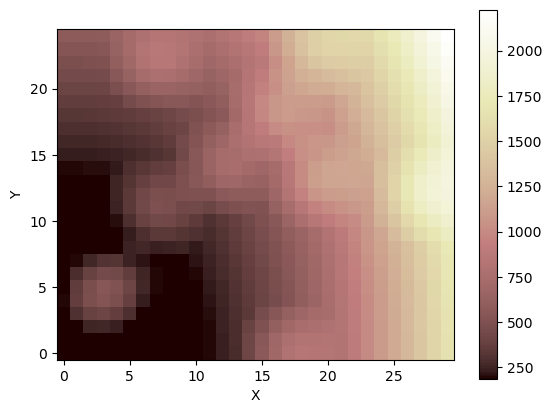

In [11]:
mg.imshow("topographic__elevation")

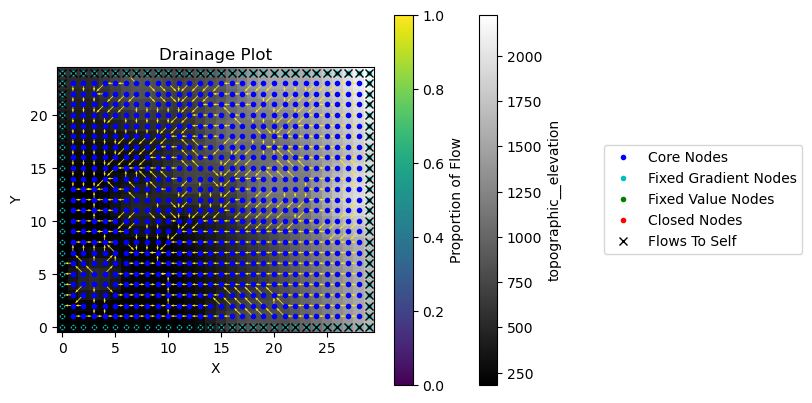

In [12]:
fa = PriorityFloodFlowRouter(mg)

# # this is the same as writing:
fa = PriorityFloodFlowRouter(
    mg,
    surface="topographic__elevation",
    flow_metric="D8",
    update_flow_depressions=True,
    runoff_rate=None,
    depression_handler="breach",
 )

fa.run_one_step()
plt.figure()
drainage_plot(mg)

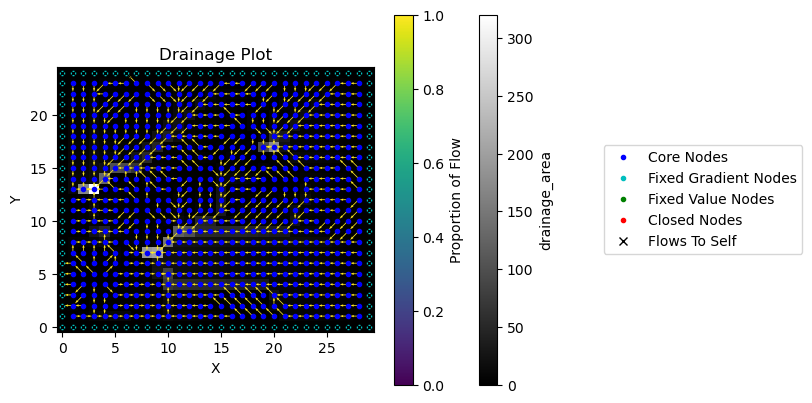

In [13]:
plt.figure()
drainage_plot(mg, "drainage_area")

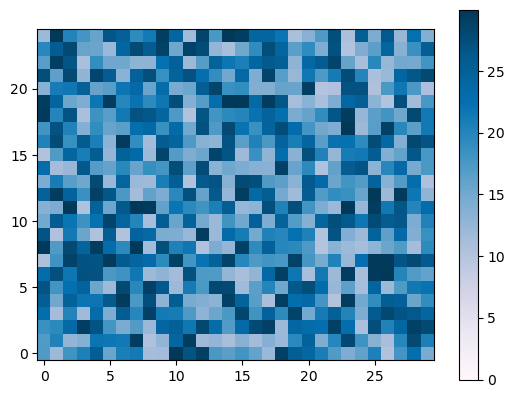

In [14]:
rain = 10.0 + 20.0 * np.random.rand(mg.number_of_nodes)
plt.imshow(rain.reshape(mg.shape), origin="lower", cmap="PuBu", vmin=0)
plt.colorbar()
plt.show()

_ = mg.add_field("water__unit_flux_in", rain, at="node", clobber=True)

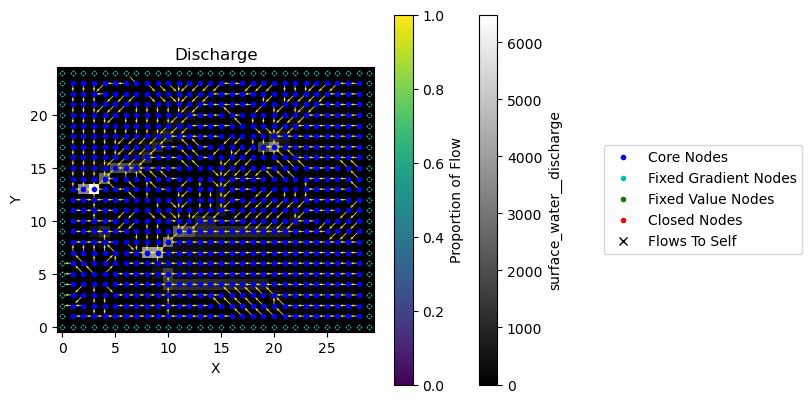

In [15]:
fa.run_one_step()
plt.figure()
drainage_plot(mg, "surface_water__discharge", title="Discharge")

TRYING EROSION

In [24]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from landlab import HexModelGrid
from landlab.components import ErosionDeposition, FlowAccumulator
from landlab.plot import imshow_grid

In [25]:
# Parameters
#dx = 100.0
K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion


run_duration = 12.0  # duration of run, yr
dt = 100.0  # time-step duration, yr
plot_every = 4.0  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])

In [26]:
ed = ErosionDeposition(
    mg,
    K=K,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit=sp_crit,
    v_s=v_s,
    F_f=F_f,
    solver="adaptive",  # use the adaptive time stepper, which is slightly faster
)

In [30]:
for i in range(1, nsteps + 1):
    # route flow
    fa.run_one_step()  # run_one_step isn't time sensitive, so it doesn't take dt as input

    # do some erosion/deposition
    ed.run_one_step(dt)

    if i * dt >= next_plot:
        plt.figure()
        imshow_mg(
            mg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every